<a href="https://colab.research.google.com/github/asamiei/mitoses_detection_/blob/main/Mitoses_Binary_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Takes in a 40 x 40 image (RGB), and determines if it is mitosis/dividing cell (=1) or normal non-dividing cell (=0) 
# The cell should be at the center, with a radius of ~30 pixels

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy
import glob

import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import albumentations as A
!pip install scikit-image==0.18.3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
!pip install segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
!pip install tensorflow-addons
#!pip install -U albumentations

     |████████████████████████████████| 50 kB 8.3 MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
     |████████████████████████████████| 1.1 MB 14.4 MB/s 


# Creating Training Dataset

In [4]:
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, RandomRotate90,
    Transpose, Flip, Compose, Rotate, OneOf, RandomBrightnessContrast)


transform = A.Compose([
                    A.HorizontalFlip(p=0.5), 
                    A.ShiftScaleRotate(p=0.75, scale_limit=0.3, shift_limit=0.20, rotate_limit=90),
                    A.RandomRotate90(p=0.5),
                    A.Rotate(p =0.5, limit=90, interpolation=cv2.INTER_CUBIC)
                    ])


def visualize(image):
    plt.figure(figsize=(2,2))
    plt.axis('on')
    plt.imshow(image)

In [5]:
#!pip install scikit-image==0.18.3
from skimage.color import rgb2hed, hed2rgb

def Macenko_H(img):
    # Separate the stains from the IHC image
    ihc_hed = rgb2hed(img)

    # Create an RGB image for each of the stains
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
    ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
    ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))
    return (ihc_h * 255).astype(np.uint8)


In [6]:
# Getting a list of images
normal_images = glob.glob("/content/gdrive/MyDrive/Alireza's_copy_MITOS dataset/Alireza_NeuroEndocrine_Dataset/Normal_40x40/*")

# Combining all the images into one numpy array
normal_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in normal_images]
normal_images_dataset = np.array([Macenko_H(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in normal_images_dataset])


# Storing/pickling
#normal_images_dataset.dump('***.npy')

In [7]:
# Augmenting the dataset
Aug_normal_images_dataset = []                 

for k in range(4):
    for i in range(np.size(normal_images_dataset, axis = 0)):
        transformed = transform(image= normal_images_dataset[i,:,:,:].astype(np.uint8))
        Aug_normal_images_dataset.append(transformed['image'])

Aug_normal_images_dataset = np.array(Aug_normal_images_dataset)
#visualize(transformed['image'])

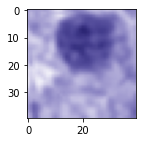

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(Aug_normal_images_dataset[14])

In [9]:
normal_images_dataset = np.concatenate((normal_images_dataset, Aug_normal_images_dataset), axis = 0)

In [10]:
np.shape(normal_images_dataset)

(12310, 40, 40, 3)

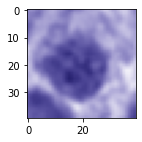

In [11]:
plt.figure(figsize=(2,2))
plt.imshow(normal_images_dataset[14])

In [12]:
np.max(normal_images_dataset[6])

249

In [13]:
mitosis_images = glob.glob("/content/gdrive/MyDrive/Alireza's_copy_MITOS dataset/Alireza_NeuroEndocrine_Dataset/Mitosis_40x40/*")

# Combining all the images into one numpy array
mitosis_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in mitosis_images]
mitosis_images_dataset = np.array([Macenko_H(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in mitosis_images_dataset])


breast_mitosis_images = glob.glob("/content/gdrive/MyDrive/MITOS dataset/mitoses_images_60x60/*")

# Combining all the images into one numpy array
breast_mitosis_images_dataset = [cv2.resize(np.load(fname), (40,40)) for fname in breast_mitosis_images]
breast_mitosis_images_dataset = np.array([Macenko_H(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in breast_mitosis_images_dataset])


# Storing/pickling
#mitosis_images_dataset.dump('***.npy')

In [14]:
larger_mitosis_images_dataset = np.concatenate((mitosis_images_dataset, breast_mitosis_images_dataset), axis = 0)

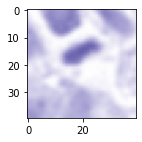

In [15]:
plt.figure(figsize=(2,2))
plt.imshow(mitosis_images_dataset[6])

In [16]:
# Augmenting the dataset
Aug_larger_mitosis_images_dataset = []                 

for k in range(6):
    for i in range(np.size(larger_mitosis_images_dataset, axis = 0)):
        transformed = transform(image= larger_mitosis_images_dataset[i,:,:,:].astype(np.uint8))
        Aug_larger_mitosis_images_dataset.append(transformed['image'])

Aug_larger_mitosis_images_dataset = np.array(Aug_larger_mitosis_images_dataset)
#visualize(transformed['image'])

In [17]:
larger_mitosis_images_dataset = np.concatenate((larger_mitosis_images_dataset, Aug_larger_mitosis_images_dataset), axis = 0)

In [18]:
np.shape(larger_mitosis_images_dataset)

(10234, 40, 40, 3)

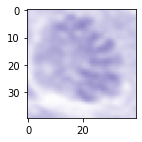

In [19]:
plt.figure(figsize=(2,2))
plt.imshow(larger_mitosis_images_dataset[3])

In [20]:
# Combining normal and mitosis images
combined_image_dataset = np.concatenate((normal_images_dataset, larger_mitosis_images_dataset), axis = 0).astype(np.uint16)

In [21]:
np.shape(combined_image_dataset)

(22544, 40, 40, 3)

In [22]:
# Assigning a label to each image
    # 0 = Normal
    # 1 = Mitosis
normal_label = np.zeros((np.size(normal_images_dataset, axis = 0)))

mitosis_label = np.ones((np.size(larger_mitosis_images_dataset, axis = 0)))

combined_label_dataset = np.concatenate((normal_label, mitosis_label))

In [23]:
np.shape(combined_label_dataset)

(22544,)

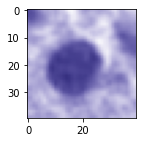

0.0

In [24]:
plt.figure(figsize=(2,2))
img_ = combined_image_dataset[4]
plt.imshow(img_)
plt.show()
combined_label_dataset[4]

# Creating Validation Dataset

In [25]:
# Getting a list of images
val_normal_images = glob.glob("/content/gdrive/MyDrive/Alireza's_copy_MITOS dataset/Alireza_NeuroEndocrine_Dataset/Test_ds_Normal_40x40/*")

# Combining all the images into one numpy array
val_normal_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in val_normal_images]
val_normal_images_dataset = np.array([Macenko_H(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in val_normal_images_dataset])


In [26]:
np.shape(val_normal_images_dataset)

(1500, 40, 40, 3)

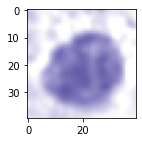

In [27]:
plt.figure(figsize=(2,2))
plt.imshow(val_normal_images_dataset[3])
plt.show()

In [28]:
val_mitosis_images = glob.glob("/content/gdrive/MyDrive/Alireza's_copy_MITOS dataset/Alireza_NeuroEndocrine_Dataset/Balanced_Val_dataset/Mits_50/*")


# Combining all the images into one numpy array
val_mitosis_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in val_mitosis_images]
val_mitosis_images_dataset = np.array([Macenko_H(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in val_mitosis_images_dataset])


In [29]:
np.shape(val_mitosis_images_dataset)

(50, 40, 40, 3)

In [30]:
# Combining normal and mitosis validation images
val_combined_image_dataset = np.concatenate((val_normal_images_dataset, val_mitosis_images_dataset), axis = 0).astype(np.uint16)

In [31]:
# Assigning a label to each image
    # 0 = Normal
    # 1 = Mitosis
val_normal_label = np.zeros((np.size(val_normal_images_dataset, axis = 0)))

val_mitosis_label = np.ones((np.size(val_mitosis_images_dataset, axis = 0)))

val_combined_label_dataset = np.concatenate((val_normal_label, val_mitosis_label))

In [32]:
np.shape(val_combined_label_dataset)

(1550,)

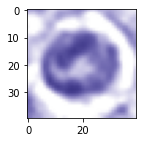

0.0

In [33]:
plt.figure(figsize=(2,2))
img_ = val_combined_image_dataset[50]
plt.imshow(img_)
plt.show()
val_combined_label_dataset[50]

# CNN

In [34]:
SIZE = 40

#Use customary x_train and y_train variables
x_train = combined_image_dataset
y_train = combined_label_dataset

x_val = val_combined_image_dataset
y_val = val_combined_label_dataset 

# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)


INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))  




#import tensorflow_addons as tfa
#metric = [tfa.metrics.F1Score(num_classes = 1, average='micro',threshold=0.5)]

model.compile(loss='binary_crossentropy',
              optimizer='adam',             
              metrics= ['accuracy'])

print(model.summary())     




##########################################################
# simple early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience= 100, restore_best_weights= True)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/saved_models/Mitoses_Binary_classification_40x40_Oct_17th.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)



history = model.fit(x_train, 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 300,      
                         validation_data=(x_val,y_val),
                         callbacks= [es, mc],
                         shuffle = True
                     )



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 38, 38, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 38, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 17, 17, 64)       2

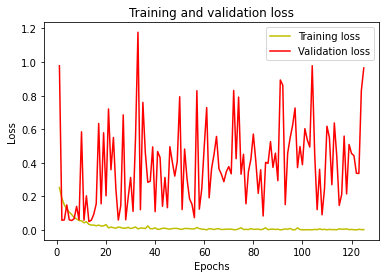

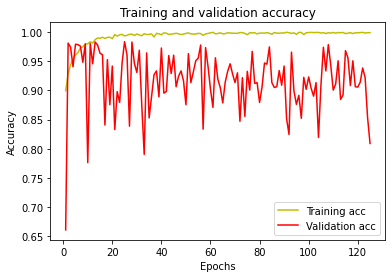

In [35]:
#plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


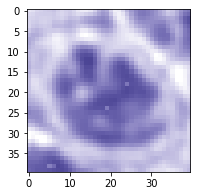

The prediction for this image is:  [[0.05026812]]
The actual label for this image is:  0.0
49/49 [==============================] - 0s 3ms/step - loss: 0.0595 - accuracy: 0.9839
Accuracy =  98.38709831237793 %
[[1460   40]
 [   3   47]]
Recall =  0.9733333333333334
Precision =  0.9979494190020506
F_measure =  0.9854876814039825


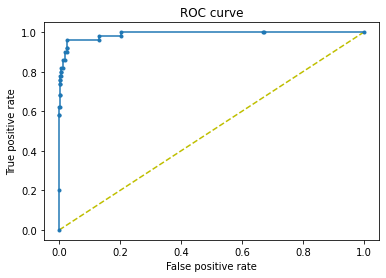

Ideal threshold is:  24    0.086787
Name: thresholds, dtype: float32
Area under curve, AUC =  0.9899600000000001


In [37]:
n=45  #Select the index of image to be loaded for testing
img = (x_val[n]).astype(np.uint16)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()


input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_val[n])


_, acc = model.evaluate(x_val, y_val)
print("Accuracy = ", (acc * 100.0), "%")


################################################################
mythreshold = 0.086787
################################################################


from sklearn.metrics import confusion_matrix

y_pred = (model.predict(x_val)>= mythreshold).astype(int)
cm = confusion_matrix(y_val, y_pred)  
print(cm)

Recall = (cm[0,0] / (cm[0,0] + cm[0,1]))
print("Recall = ", Recall)

Precision = (cm[0,0] / (cm[0,0] + cm[1,0]))
print("Precision = ", Precision)

F_measure = (2 * Recall * Precision) / (Recall + Precision)
print("F_measure = ", F_measure )


#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(x_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_preds)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()


import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 


from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)
